## This Notebook shows the usage of Pre-trained TTM model for the short-term energy demand forecasting task in Zero-Shot fashion.

Zero-Shot forecasting means the model directly produces the forecast on target data without any training on the target domain data.

### Install the TSFM Library 

The [granite-tsfm library](https://github.com/ibm-granite/granite-tsfm) provides utilities for working with IBM Granite Time Series Foundation Models (TSFM). Here the pinned version is retrieved and installed.

In [1]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks]==0.3.1"

### Imports

In [2]:
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt

from tsfm_public import (
    TimeSeriesForecastingPipeline,
    TinyTimeMixerForPrediction,
    TimeSeriesPreprocessor,
)

### Specify time and output variables

We provide the names of the timestamp column and the target column to be predicted. The context length (in time steps) is set to match the pretrained model.

In [3]:
timestamp_column = "timestamp"
target_columns = ["meter_reading"]   # have to list all the target columns for which forecast is needed
context_length = 512  # context length and forecast length has to be set according to the pretrained TTM model being used
forecast_length=96

### Read in the data

We parse the csv into a pandas dataframe, filling in any null values, and create a single window containing `context_length` time points. We ensure the timestamp column is a datetime.

In [ ]:
DATA_FILE_PATH='test.csv'

In [5]:
input_df = pd.read_csv(
    DATA_FILE_PATH,
    parse_dates=[timestamp_column],  # Parse the timestamp values as dates.
)


### Visualizaing the data
Plotting randomly selected windows of the data

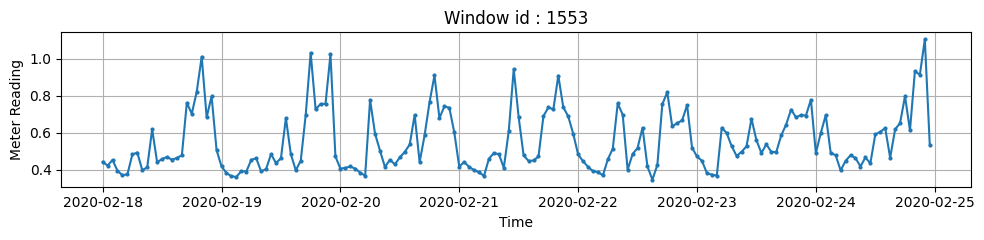

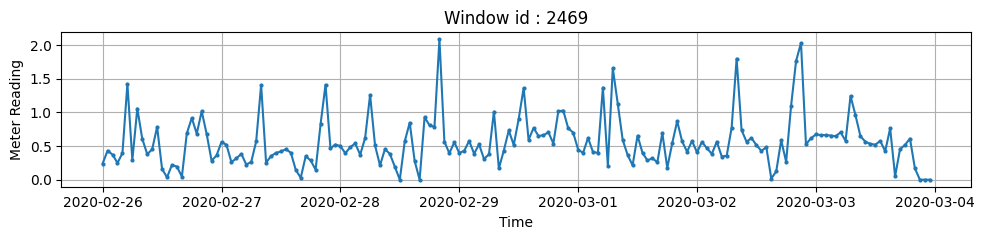

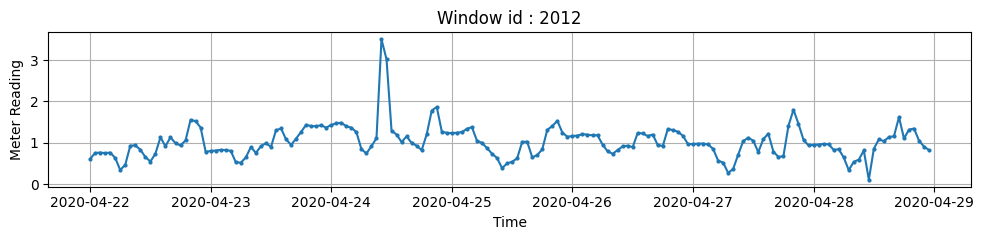

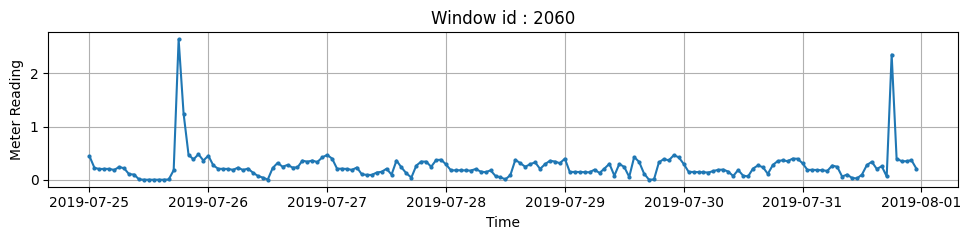

In [6]:
import random
window_ids = input_df["window_id"].unique().tolist()  
random_windows = random.sample(window_ids, 4)

for w in random_windows:
    window_df = input_df[input_df["window_id"] == w]
    plt.figure(figsize=(10, 2.5))
    plt.plot(window_df["timestamp"], window_df["meter_reading"], marker="o", ms=2)
    plt.xlabel("Time")
    plt.ylabel("Meter Reading")
    plt.title(f"Window id : {w}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Set up zero shot model
The TTM model is hosted on [Hugging Face](https://huggingface.co/ibm-granite/granite-timeseries-ttm-v1), and is retrieved by the wrapper, `TinyTimeMixerForPrediction`. We have one input channel in this example.
Different TTM models with different input context lengths can be used. For eg. you can try models with context length 180 or 512 as shown below.

In [7]:
# Instantiate the model.

# zeroshot_model = TinyTimeMixerForPrediction.from_pretrained( 
#     "ibm-granite/granite-timeseries-ttm-r2",  # 180-60 model
#     revision='180-60-ft-l1-r2.1',
#     num_input_channels=len(target_columns), 
# )

zeroshot_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm-granite/granite-timeseries-ttm-r1",  # 512-96 TTM model
    revision='main',
    num_input_channels=len(target_columns), 
)

### Create the tsp (Time Series Processor)

tsp is used to sanitize and do the needed scaling on the input data.

In [8]:
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": [],
    "target_columns": target_columns,
    "control_columns": [],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    forecast_length=forecast_length,
    scaling=True,
    scaler_type="standard",
    freq='h'
)

tsp.train(input_df)

TimeSeriesPreprocessor {
  "categorical_columns": [],
  "categorical_encoder": null,
  "conditional_columns": [],
  "context_length": 512,
  "control_columns": [],
  "encode_categorical": true,
  "feature_extractor_type": "TimeSeriesPreprocessor",
  "forecast_length": 96,
  "freq": "h",
  "frequency_mapping": {
    "10min": 4,
    "15min": 5,
    "2min": 2,
    "30min": 6,
    "5min": 3,
    "D": 8,
    "H": 7,
    "W": 9,
    "d": 8,
    "h": 7,
    "min": 1,
    "oov": 0
  },
  "id_columns": [],
  "observable_columns": [],
  "prediction_length": null,
  "processor_class": "TimeSeriesPreprocessor",
  "scale_categorical_columns": true,
  "scaler_dict": {},
  "scaler_type": "standard",
  "scaling": true,
  "scaling_id_columns": [],
  "scaling_id_columns_types": [],
  "static_categorical_columns": [],
  "target_columns": [
    "meter_reading"
  ],
  "target_scaler_dict": {
    "0": {
      "copy": true,
      "feature_names_in_": [
        "meter_reading"
      ],
      "mean_": [
      

### Create a forecasting pipeline

A pipeline is used for inference from a pretrained model. Here we instantiate a forecasting pipeline using our pretrained TTM model.

In [9]:
# Create a pipeline.
device = "cuda" if torch.cuda.is_available() else "cpu"

pipeline = TimeSeriesForecastingPipeline(
    zeroshot_model,
    explode_forecasts=True,
    feature_extractor=tsp,
    device=device,  # Specify your local GPU or CPU.
)


Device set to use cpu


## Running on all windows

In [10]:
input_df = pd.read_csv(
    DATA_FILE_PATH,
    parse_dates=[timestamp_column],  # Parse the timestamp values as dates.
)
window_ids = input_df["window_id"].unique().tolist()   # list of all the different window ids on which prediction has to be made

submission = pd.DataFrame()

for wi in window_ids:
    window_df = input_df[input_df["window_id"] == wi]
    current_input_df = window_df[window_df["role"].isin(['input'])]
    current_output_df = window_df[window_df["role"].isin(['target'])]
    zeroshot_forecast = pipeline(current_input_df)
    zeroshot_forecast = zeroshot_forecast.iloc[:24]  # taking the first forecast_length=24 outputs 
    submission_temp = pd.DataFrame({
        "row_id": current_output_df['row_id'].reset_index(drop=True),
        "meter_reading" : zeroshot_forecast['meter_reading'].reset_index(drop=True)
        })
    submission = pd.concat([submission, submission_temp], axis=0).reset_index(drop=True)



In [11]:
submission

,row_id,meter_reading
0,169,0.432022
1,170,0.465076
2,171,0.481063
3,172,0.493179
4,173,0.508184
...,...,...
84595,676796,0.867675
84596,676797,0.818650
84597,676798,0.823902
84598,676799,0.848374


In [12]:
submission.to_csv("submission.csv", index=False)

### Finetuning of the TTM model

Apart from the target variable 'meter_reading' a lot of other metadata has been provided in the `metadata.csv` which can be used as exogenous variable to finetune the TTM model and further improve the forecast.
Refer to the notebook to see an example of TTM finetuning with exogenous variables : https://github.com/ibm-granite-community/granite-timeseries-cookbook/blob/main/recipes/Time_Series/Bike_Sharing_Finetuning_with_Exogenous.ipynb

### Important Links

Public granite tsfm repository : https://github.com/ibm-granite/granite-tsfm/tree/main  


Model Code of TTM : https://github.com/ibm-granite/granite-tsfm/tree/main/tsfm_public/models/tinytimemixer   


Huggingface Repository of TTM models : https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2